# Calculate Grounding Zone Widths

For a given region, group grounding lines together and create a polygon, then use the boundary of that polygon to get the width of the grounding zone.

## NOTES
Making buffer for lines individually (instead of converting to MultiLineString first) and then creating multi polygon might be faster than current way.

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pyproj
from shapely.geometry import Polygon,MultiLineString
from shapely import ops
from descartes import PolygonPatch

In [2]:
%matplotlib widget

In [3]:
base_dir = os.path.expanduser('~')
#-- specify GL file
file_6d = os.path.join(base_dir,'GL_learning_data','6d_results','AllTracks_6d_GL.shp')

In [4]:
gdf = gpd.read_file(file_6d)

Read boundary of ice shelf in order to get intersection with lines:

In [5]:
basins = gpd.read_file(os.path.join(base_dir,'data.dir','basin.dir','Gates_Basin_v1.7','Basins_v2.4.shp'))

In [6]:
basins

,NAME,Regions,Subregion2,Subregion,SLE,geometry
0,LarsenE,Peninsula,LarsenE_Ice_Shelf,"I""-J",0.77,"POLYGON ((-1604213.024 911528.811, -1603107.44..."
1,Coats_Coast,East,Coats_Coast,K-A,4.94,"POLYGON ((-681761.563 1361890.885, -680167.251..."
2,Academy,East,Filchner_Ice_Shelf,"J""-K",247.33,"POLYGON ((-650545.636 590416.431, -644265.131 ..."
3,Stancomb_Wills,East,Stancomb_Wills_Ice_Shelf,K-A,46.14,"POLYGON ((-549906.633 1305863.952, -572323.238..."
4,Riiser-Larsen,East,Riiser-Larsen_Ice_Shelf,K-A,19.00,"POLYGON ((-418449.622 1964493.872, -417441.371..."
...,...,...,...,...,...,...
196,Enderby_Land2,East,Enderby_Land_2,A'-B,0.00,"POLYGON ((2120087.293 1409593.226, 2120761.769..."
197,David,East,Drygalski_Ice_Shelf,D'-E,117.99,"POLYGON ((1362451.207 -906394.029, 1362282.310..."
198,Islands,Islands,Islands,Islands,8.76,"MULTIPOLYGON (((-2630075.000 1586825.000, -262..."
199,Islands,Islands,Islands,Islands,0.00,"POLYGON ((-1453517.353 311789.988, -1453035.86..."


In [7]:
idx = basins.index[basins['NAME']=='Getz']

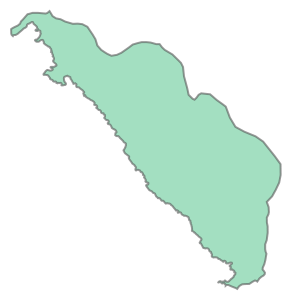

In [8]:
#-- get polygon
poly = basins['geometry'][idx[0]]
poly

In [9]:
#-- add a 5km buffer to finding the corresponding GLs
region_poly = poly.buffer(5e3)

Go through lines and find those that intersect the region:

In [10]:
lines = []
for i in range(len(gdf)):
    #-- extract geometry to see if it's in region of interest
    ll = gdf['geometry'][i]
    if ll.intersects(region_poly):
        lines.append(ll)

In [11]:
#-- merge all lines into linestring
lm = ops.linemerge(lines)

In [12]:
#-- convert to polygon with small buffer (10cm)
ep = lm.buffer(1e-1)

In [13]:
len(ep)

64

In [14]:
# buffer_list = []
# for il in lines:
#     buffer_list.append(il.buffer(1e-1))
# ep = ops.unary_union(buffer_list)

In [15]:
#-- get the boundary of the polygon containing all lines to make new polygon of just the envelope
err_poly = []
for ip in ep:
    x,y = ip.exterior.coords.xy
    err_poly.append(Polygon(zip(x,y)))

In [16]:
# fig = plt.figure(1,figsize=(8,8))
# ax = fig.add_subplot(111)
# for il in lines:
#     xs,ys = il.coords.xy
#     ax.plot(xs,ys,linewidth=0.4,alpha=0.8,color='k',zorder=1)
# for ip in err_poly:
#     pp = PolygonPatch(ip,alpha=0.3,fc='red',ec='darkred')
#     ax.add_patch(pp)
# plt.show()

In [17]:
for p in err_poly:
    width = p.area/p.length
    if width > 1:
        print('Width {0:.1f}m'.format(width))

Width 628.5m
Width 95.1m
Width 435.5m
Width 187.8m
Width 93.6m
Width 441.5m
Width 384.7m
Width 759.5m
Width 478.4m
Width 353.7m
Width 153.5m
Width 355.6m
Width 122.8m
Width 1137.7m
Width 535.1m
Width 406.6m
Width 510.7m
Width 216.2m
Width 675.9m
Width 664.6m
Width 285.9m
Width 710.6m
Width 176.2m
Width 670.0m
Width 488.0m
Width 340.5m
Width 389.0m
Width 817.8m
Width 391.2m


In [36]:
#-- save the error polygon
#-- first make DataFrame
df = {'REGION':[],'center_x':[],'center_y':[]}
out_geo = []
for p in err_poly:
    width = p.area/p.length
    if width > 1:
        df['REGION'].append('Getz')
        x,y = p.centroid.coords.xy
        df['center_x'].append(x[0])
        df['center_y'].append(y[0])
        out_geo.append(p)

In [55]:
out_gdf = gpd.GeoDataFrame(df,geometry=out_geo,crs=gdf.crs)
out_gdf

,REGION,center_x,center_y,geometry
0,Getz,-1.179152e+06,-1.135708e+06,"POLYGON ((-1191346.392 -1144821.727, -1191346...."
1,Getz,-1.182674e+06,-1.169386e+06,"POLYGON ((-1192516.284 -1176585.357, -1192503...."
2,Getz,-1.180459e+06,-1.152397e+06,"POLYGON ((-1187410.563 -1150257.466, -1187410...."
3,Getz,-1.185340e+06,-1.135726e+06,"POLYGON ((-1188945.617 -1137063.131, -1188945...."
4,Getz,-1.192447e+06,-1.187365e+06,"POLYGON ((-1196886.446 -1183531.010, -1196886...."
5,Getz,-1.221178e+06,-1.120496e+06,"POLYGON ((-1244620.020 -1092406.103, -1244620...."
6,Getz,-1.194169e+06,-1.147490e+06,"POLYGON ((-1194699.945 -1148969.555, -1194699...."
7,Getz,-1.195157e+06,-1.166720e+06,"POLYGON ((-1194549.978 -1168294.750, -1194549...."
8,Getz,-1.205649e+06,-1.174930e+06,"POLYGON ((-1209099.277 -1174514.881, -1209086...."
9,Getz,-1.256541e+06,-1.078641e+06,"POLYGON ((-1259224.367 -1079270.824, -1259299...."


In [69]:
outfile = os.path.join(base_dir,'GL_learning_data','GZ_Getz.shp')

In [ ]:
out_gdf.to_file(outfile,driver='ESRI Shapefile')

In [71]:
#-- also save GZ widths to file
fid = open(outfile.replace('.shp','.csv'),'w')
fid.write('Center_X,Center_Y,WIDTH(m,LENGTH(m),AREA(m2)\n')
for i in range(len(out_gdf)):
    fid.write('{0:.2f},{1:.2f},{2:.1f},{3:.1f},{4:.1f}\n'.format(
        out_gdf['center_x'][i],
        out_gdf['center_y'][i],
        out_gdf['geometry'][i].area/out_gdf['geometry'][i].length,
        out_gdf['geometry'][i].length,
        out_gdf['geometry'][i].area
    ))
fid.close()

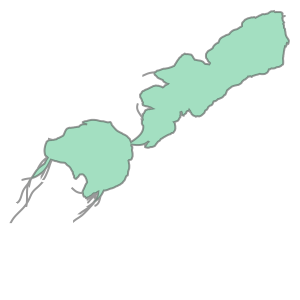

In [60]:
out_geo[0]

In [64]:
print('area: ',out_geo[0].area)
print('Length: ',out_geo[0].length)
print('Width: ',out_geo[0].area/out_geo[0].length)

area:  73697762.17590474
Length:  117256.65723412731
Width:  628.5166566598588
